In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 
quandl.ApiConfig.api_key = 'nnzjYSFqsUsnhYvVVzya'

In [3]:
# Importing Inflation Rates "Consumer Price Index - Germany" variable.
data = quandl.get('RATEINF/CPI_DEU')

In [4]:
data.head(5)

,Value
Date,
1991-01-31,64.0
1991-02-28,64.3
1991-03-31,64.3
1991-04-30,64.5
1991-05-31,64.7


In [5]:
data.shape

(371, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

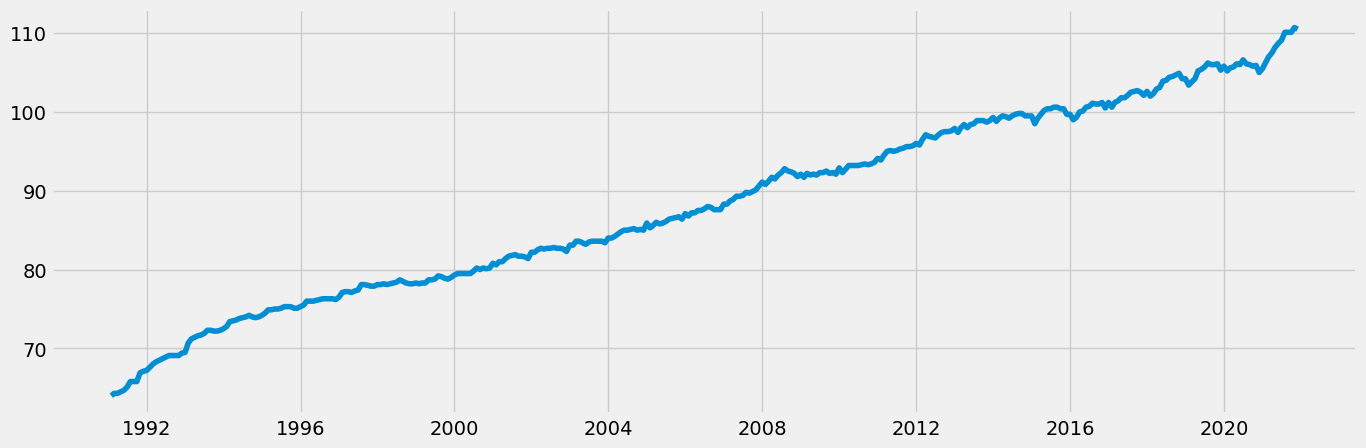

In [8]:
# Ploting the data using matplotlib.
plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

# 2. Subsetting, wrangling, and cleaning time-series data

In [9]:
# Reseting index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,1991-01-31,64.0
1,1991-02-28,64.3
2,1991-03-31,64.3
3,1991-04-30,64.5
4,1991-05-31,64.7


In [11]:
data_sub = data_2.loc[(data_2['Date'] >= '2018-01-01') & (data_2['Date'] < '2020-12-31')]

I chose the 2010-2020 data points because I only want to look at the current data, as the data from my project also refers to current data. 

In [12]:
data_sub.shape

(35, 2)

In [13]:
data_sub.head()

,Date,Value
324,2018-01-31,102.0
325,2018-02-28,102.3
326,2018-03-31,102.9
327,2018-04-30,103.1
328,2018-05-31,103.9


In [14]:
# Seting the "Date" column as the index
from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2018-01-31,102.0
2018-02-28,102.3
2018-03-31,102.9
2018-04-30,103.1
2018-05-31,103.9


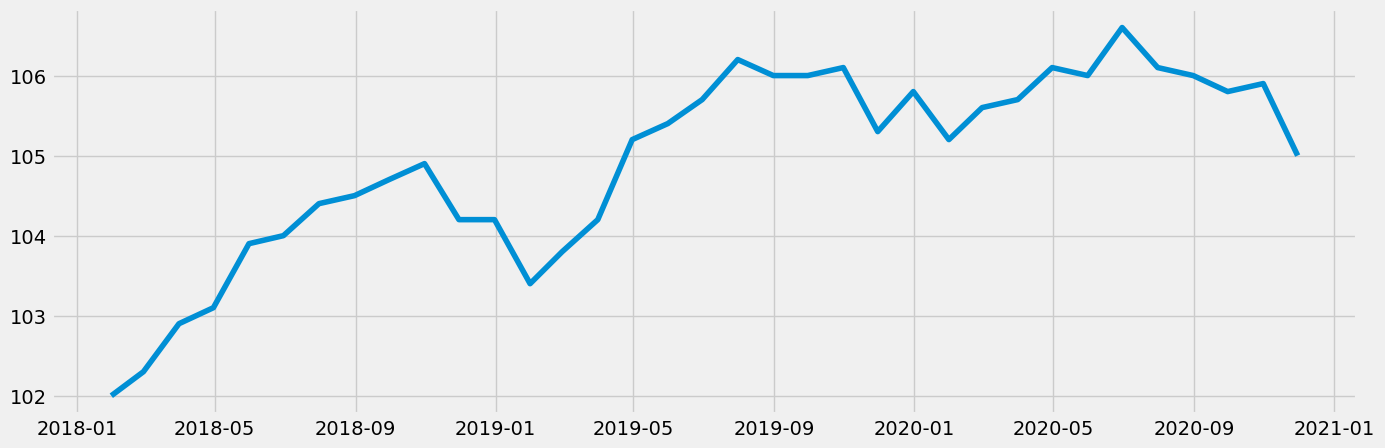

In [15]:
# Ploting the new data set
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [16]:
# Checking for missing values
data_sub.isnull().sum() 

Value    0
dtype: int64

# 3. Time-series analysis: decomposition

In [17]:
# Decomposing the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [18]:
# Defining a fixed size for all special charts.
from pylab import rcParams #

rcParams['figure.figsize'] = 18, 7

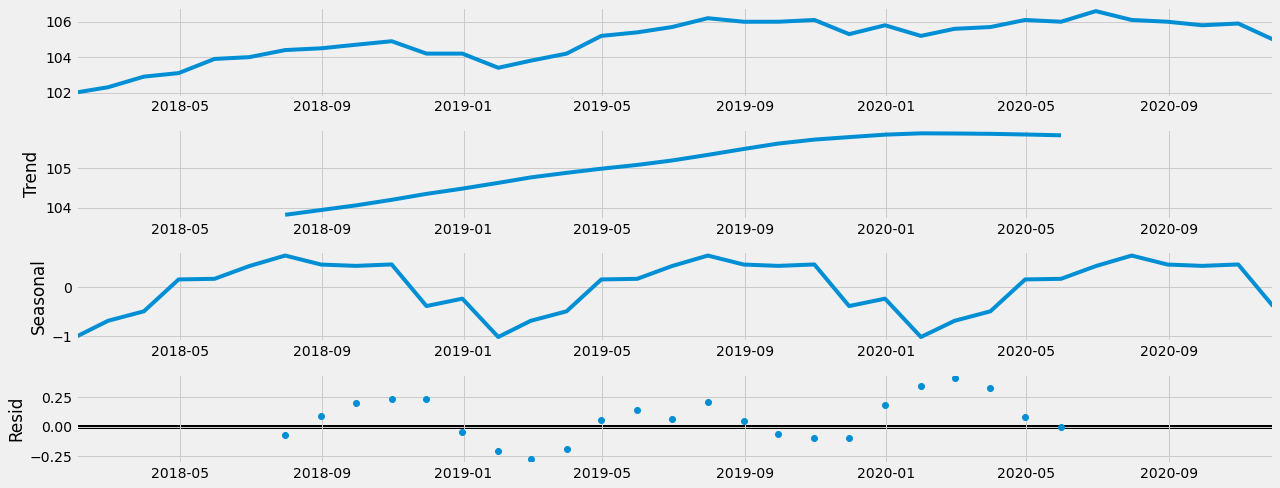

In [19]:
# Plot the separate components
decomposition.plot()
plt.show()

The first diagram, in the figure above, the level, shows the data itself (including all its components).

The second graph shows the underlying rising trend. The trend increases gradually and linearly after 2018-09. It seems to be a dominant trend.

With seasonality, one sees the seasonal fluctuations represented by the three bulges/curves that repeat similarly at regular intervals. Since the curve is not flat, there is seasonality.

You can see that there is not much unexplained noise.

# 4. Testing for stationarity

In [20]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Applying the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.305469
p-value                         0.170210
Number of Lags Used             2.000000
Number of Observations Used    32.000000
Critical Value (1%)            -3.653520
Critical Value (5%)            -2.957219
Critical Value (10%)           -2.617588
dtype: float64


The Critical Value 5% has a value of -2.957219. This is a bit smaller than the test statistic, which is -2.305469, which means that I can’t reject the null hypothesis. So the data is non-stationary.

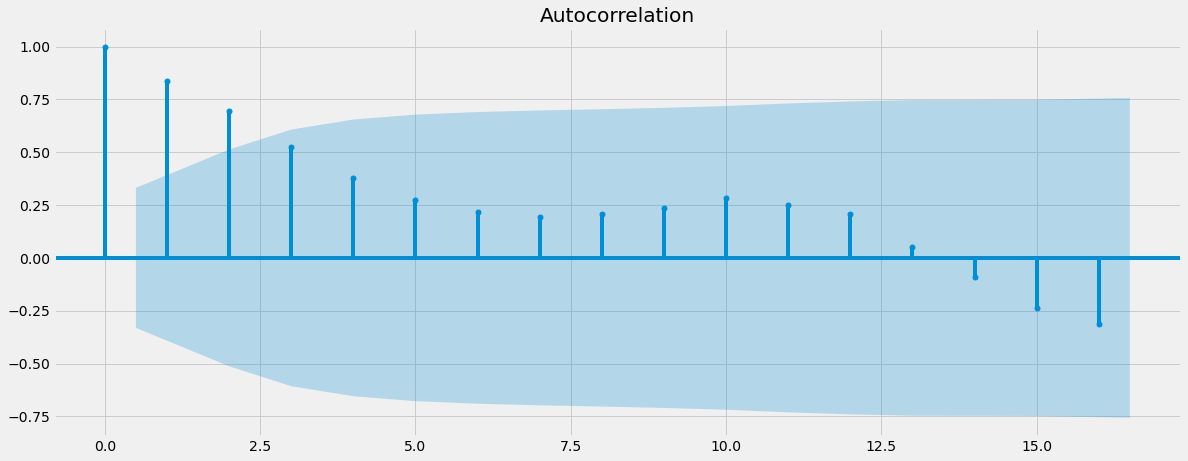

In [21]:
# Checking out a plot of autocorrelations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

I have only a few lags beyond this interval, I cannot deduce that  my data is non-stationary.

Because the Dicky Fuller test shows that the data are not stationary, I perform a round differentiation.

# 5. Stationarizing the Federal Reserve Economic Data

In [22]:
# The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)
data_diff = data_sub - data_sub.shift(1)

In [23]:
# Removing the missing values that came about as a result of the differencing. (need to remove these or you won't be able to run the Dickey-Fuller test.)

data_diff.dropna(inplace = True) 

In [24]:
data_diff.head()

,Value
datetime,
2018-02-28,0.3
2018-03-31,0.6
2018-04-30,0.2
2018-05-31,0.8
2018-06-30,0.1


In [25]:
data_diff.columns

Index(['Value'], dtype='object')

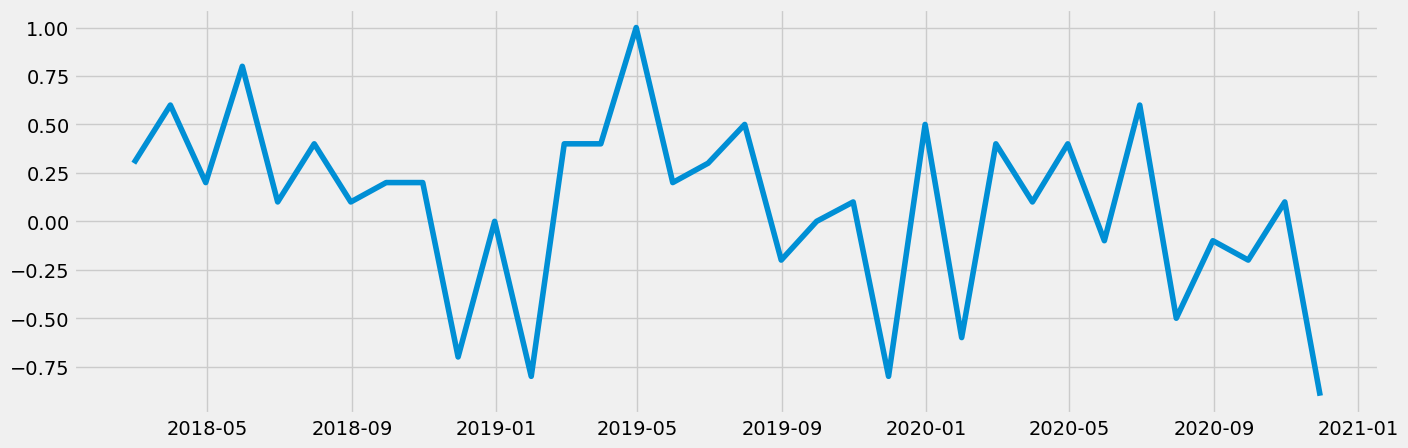

In [26]:
# Checking out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [27]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.266748
p-value                         0.016432
Number of Lags Used             4.000000
Number of Observations Used    29.000000
Critical Value (1%)            -3.679060
Critical Value (5%)            -2.967882
Critical Value (10%)           -2.623158
dtype: float64


The Critical Value 5% has a value of -2.957219. This bigger than the test statistic, which is -3.266748, which means that I can reject the null hypothesis. So the data is stationary.

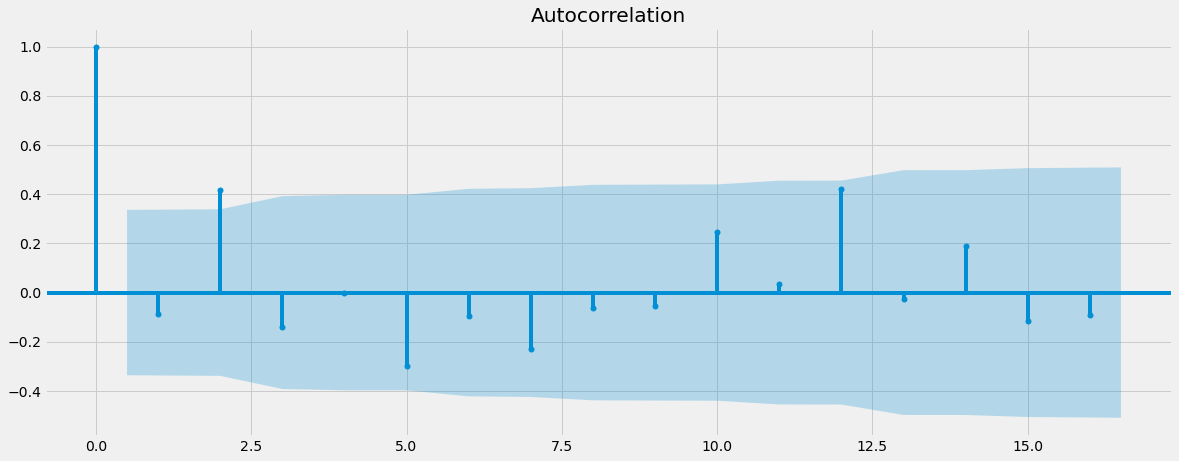

In [28]:
plot_acf(data_diff)
plt.show()

The autocorrelation plot has improved. I have here fewer lags beyond this interval, I cannot deduce that  my data is non-stationary.

In [31]:
path = r'C:\Users\s.wienecke\Documents\Fortbildung\Letztes Modul'

In [32]:
# export data_sub to folder Prepared Data
data_sub.to_csv(os.path.join(path, '02 Data','Prepared Data', 'timeseries_clean.csv'))